In [47]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


SIF를 이용한 문장 임베딩 실습

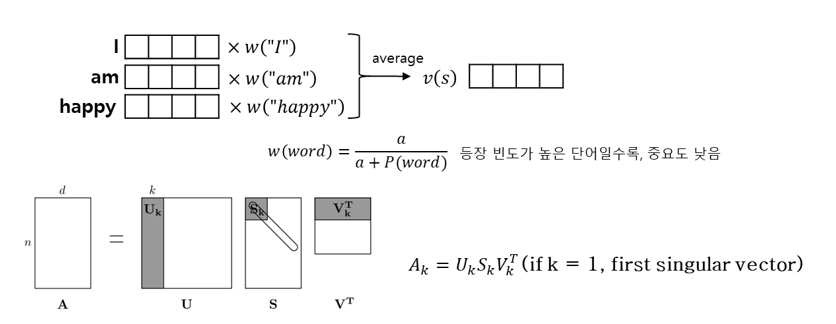

In [48]:
from IPython.display import Image
import os
root_dir = "/gdrive/My Drive/NLP"
Image(os.path.join(root_dir, "SIF_embedding.PNG"))

In [49]:
from __future__ import print_function
import numpy as np
from tqdm import tqdm

def getWordmap(word_emb_file, dims):
    '''
    단어 임베딩 파일을 읽어서 딕셔너리에 저장해주는 함수

    :param word_emb_file: 단어 임베딩 파일
    :param dims: 단어 벡터의 크기
    :return: work2idx : 단어에 대응되는 인덱스 값을 저장한 딕셔너리
              embedding : 단어 인덱스에 대응되는 단어 벡터 값을 저장한 딕셔너리
    '''
    print("Embedding file Loading...")
    word2idx={}

    f = open(word_emb_file,'r')
    lines = f.readlines()
    embedding = np.zeros(shape=(len(lines), dims))
    for (idx,line) in enumerate(tqdm(lines)):
      # line : 집 0.1 0.6 0.4 0.4
        line=line.split()
        word, vector = line[0], [float(e) for e in line[1:]]
        word2idx[word]=idx
        embedding[idx] = vector
    return word2idx, embedding

def prepare_data(indexing_sentences):
    '''
    인덱싱된 문장 리스트를 고정 길이의 array로 표현하기 위한 함수
    [나는, 사과를, 좋아해] ==> [54, 9, 15] ==> [54, 9, 15, 0, 0]
    :param indexing_sentences: 인덱스로 치환된 문장 리스트
    :return: sentence_matrix : "문장 수 X 최대 문장 길이"로 표현된 익덱싱된 문장 array
              sentences_mask : 각 문장 array의 요소 유무에 따른 mask array
              ex - [2, 54, 1, 8, 0, 0] ==> [1, 1, 1, 1, 0, 0]
    '''
    lengths = [len(s) for s in indexing_sentences]
    n_samples = len(indexing_sentences)
    maxlen = np.max(lengths)
    sentences_matrix = np.zeros((n_samples, maxlen)).astype('int32')
    sentences_mask = np.zeros((n_samples, maxlen)).astype('float32')

    for idx, s in enumerate(indexing_sentences):
        sentences_matrix[idx, :lengths[idx]] = s
        sentences_mask[idx, :lengths[idx]] = 1.
    sentences_mask = np.asarray(sentences_mask, dtype='float32')
    return sentences_matrix, sentences_mask

def lookupIDX(word2idx,word):
    word = word.lower()

    if word in word2idx.keys():
        return word2idx[word]
    elif 'unk' in word2idx:
        return word2idx['unk']
    else:
        return len(word2idx) - 1

def getSeq(sentence, word2idx):
    '''
    단어로 이루어진 문장 리스트를 인덱스로 치환하기 위한 함수

    :param sentence: 단어로 이루어진 문장 리스트
    나는 밥을 먹는다. ==> [나는, 밥을, 먹는다]
    :param word2idx: word2idx 딕셔너리
    :return:
    '''
    sentence = sentence.split()
    indexing_sentence = []
    for word in sentence:
        indexing_sentence.append(lookupIDX(word2idx,word))
    return indexing_sentence

def sentences2idx(sentences, word2idx):
    '''
    자연어 문장 리스트를 인덱스로 치환 후, 고정 길이 array로 변환해주는 함수

    :param sentences:  자연어로 이루어진 문장 리스트
    :param word2idx: word2idx 딕셔너리
    :return: sentences_matrix : 인덱스로 치환된 문장 array
              sentences_mask : 각 문장 array의 요소 유무에 따른 mask array
    '''
    indexing_sentences = []
    for sentence in sentences:
        indexing_sentences.append(getSeq(sentence,word2idx))
    sentences_matrix, sentences_mask = prepare_data(indexing_sentences)

    return sentences_matrix, sentences_mask


def getWordWeight(weightfile, rate=1e-3):
    '''

    :param weightfile: 단어 빈도 수가 저장된 파일
    :param rate: 빈도 수에 따른 가중치 계산에 필요한 비율 값
    :return:
    '''
    word2weight = {}
    with open(weightfile) as f:
        lines = f.readlines()
    sum_weights = 0
    print("Weight file Loading...")
    for line in tqdm(lines):
      # 집 68451
        line = line.strip().split()

        assert len(line) == 2
        word, weight = line
        word2weight[word] = float(weight)
        sum_weights += float(weight)

    for word, weight in word2weight.items():
        word2weight[word] = rate / (rate + weight/sum_weights)

    return word2weight

def getWeight(word2idx, word2weight):
    '''
    word2idx 딕셔너리와 word2weight 딕셔너리를 기반으로 idx2weight 딕셔너리 생성

    :param word2idx:
    :param word2weight:
    :return:
    '''
    print("Make idx2weight...")
    idx2weight = {}
    for word, idx in tqdm(word2idx.items()):
        if word in word2weight:
            idx2weight[idx] = word2weight[word]
        else:
            idx2weight[idx] = 1.0
    return idx2weight

def seq2weight(indexing_sentences, sentences_mask, idx2weight):
    '''
    입력 문장을 구성하는 단어의 가중치를 계산하는 함수
    :param indexing_sentences:
    :param sentences_mask:
    :param idx2weight:
    :return: weight : 문장 리스트의 가중치를 저장한 array
            ex - indexing_sentences = [[1, 2, 3, 4, 0, 0], [...], ...]
                 sentence_mask = [[1, 1, 1, 1, 0, 0], [...], ...]
                 idx2weight = {1:0.1, 2:0.2, 3:0.3, ...}

                 weight = [[0.1, 0.2, 0.3, 0.4, 0, 0], [...], ..., ]
    '''
    weight = np.zeros(indexing_sentences.shape, dtype=np.float32)
    for i in range(indexing_sentences.shape[0]):
        for j in range(indexing_sentences.shape[1]):
            if sentences_mask[i, j] > 0 and indexing_sentences[i, j] >= 0:
                weight[i,j] = idx2weight[indexing_sentences[i,j]]
    weight = np.asarray(weight, dtype='float32')
    return weight


In [50]:
import numpy as np
from sklearn.decomposition import TruncatedSVD


def get_weighted_average(idx2embedding, indexing_sentences, sentence_weights):
    """
    가중치를 반영한 단어 벡터 열을 생성하기 위한 함수

    :param idx2embedding: word_embedding[i,:]  i 번 째 단어 벡터를 저장한 딕셔너리
    :param indexing_sentences: indexing_sentences[i, :] 인덱스로 치환된 고정길이의 i 번째 문장
    :param sentence_weights: sentence_weights[i, :] i 번째 문장을 구성하는 단어의 중요도에 따른 가중치
    :return: emb[i, :] i 번째 문장을 구성하는 단어 가중치 X 단어 벡터를 저장한 array
    """
    n_samples = indexing_sentences.shape[0]
    sentence_embedding_matrix = np.zeros((n_samples, idx2embedding.shape[1]))
    for i in range(n_samples):
        sentence_embedding_matrix[i,:] = sentence_weights[i,:].dot(idx2embedding[indexing_sentences[i,:],:])/ np.count_nonzero(sentence_weights[i,:])
    return sentence_embedding_matrix

def compute_pc(sentence_embedding_matrix):
    """
    입력 문장들의 벡터를 기반으로 공통 성분을 계산하는 함수
    :param sentence_embedding_matrix: sentence_embedding_matrix[i,:] i번째 문장 벡터
    :return: component_ 전체 문장을 기반으로 계산된 공통 정보 벡터
    """
    svd = TruncatedSVD(n_components=1, n_iter=7)
    svd.fit(sentence_embedding_matrix)
    return svd.components_

def remove_pc(sentence_embedding_matrix):
    """
    파라미터로 입력받은 문장 벡터 array에서 전체 문장 공통 성분을 제거하기 위한 함수

    :param sentence_embedding_matrix: sentence_embedding_matrix[i,:] i 번째 문장 벡터
    :return: 문장 공통 성분이 제거된 문장 벡터들의 array
    """
    pc = compute_pc(sentence_embedding_matrix)

    refine_sentence_embedding_matrix = sentence_embedding_matrix 
    - sentence_embedding_matrix.dot(pc.transpose()) * pc
    # 5문장
    # (5,1)

    return refine_sentence_embedding_matrix


def SIF_embedding(idx2embedding, indexing_sentences, sentence_weights):
    '''

    :param idx2embedding:
    :param indexing_sentences:
    :param sentence_weights: 
    :return:
    '''
    emb = get_weighted_average(idx2embedding, indexing_sentences, sentence_weights)

    emb = remove_pc(emb)
    return emb



In [51]:
import os

def cos_sim(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

if __name__ == "__main__":
    
    flags = {
        "word_embedding_file_path":os.path.join(root_dir,"wiki-news-300d-1M.vec"),
        "word_weight_file_path": os.path.join(root_dir, "word_count.txt"),
        "weight":1e-3,
        "word_dims":300
    }

    sentences = ['I like an apple because it tastes good', 'an apples is delicious', 'there is too much work to do', 'I am busy with my work']
    
    # load word vectors
    (word2idx, idx2embedding) = getWordmap(flags["word_embedding_file_path"], flags["word_dims"])
    
    # load word weights
    word2weight = getWordWeight(flags["word_weight_file_path"], flags["weight"]) # word2weight['str'] is the weight for the word 'str'
    idx2weight = getWeight(word2idx, word2weight) # weight4ind[i] is the weight for the i-th word
    # load sentences
    sentences_matrix, sentences_mask = sentences2idx(sentences, word2idx) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
    sentence_weights = seq2weight(sentences_matrix, sentences_mask, idx2weight) # get word weights

    # get SIF embedding
    sentence_embedding_matrix = SIF_embedding(idx2embedding, sentences_matrix, sentence_weights) # embedding[i,:] is the embedding for sentence i


    for i in range(len(sentence_embedding_matrix)):
        for j in range(len(sentence_embedding_matrix)):
            if j>i:
                sim = cos_sim(sentence_embedding_matrix[i], sentence_embedding_matrix[j])
                print("\nCos Similiarity score between '{}' and '{}' : {}\n".format(sentences[i], sentences[j], sim))

Embedding file Loading...


 40%|███▉      | 74895/188033 [00:00<00:00, 748943.57it/s]

Weight file Loading...


 12%|█▏        | 122723/999995 [00:00<00:00, 1227228.24it/s]

Make idx2weight...


100%|██████████| 999995/999995 [00:00<00:00, 1476347.66it/s]



Cos Similiarity score between 'I like an apple because it tastes good' and 'an apples is delicious' : 0.7784683618043271


Cos Similiarity score between 'I like an apple because it tastes good' and 'there is too much work to do' : 0.7356923098021675


Cos Similiarity score between 'I like an apple because it tastes good' and 'I am busy with my work' : 0.6645378490338248


Cos Similiarity score between 'an apples is delicious' and 'there is too much work to do' : 0.5712308467939553


Cos Similiarity score between 'an apples is delicious' and 'I am busy with my work' : 0.5339338564135022


Cos Similiarity score between 'there is too much work to do' and 'I am busy with my work' : 0.7549703762966761

